<a href="https://colab.research.google.com/github/oopstayuno/ML-Project/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np

from tqdm import tqdm
from numpy import array
from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, concatenate, Dense, GlobalAveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [4]:
os.listdir('drive/My Drive/ML Project NITT/')

['NB_Numodril.ipynb',
 'Dataset.zip',
 'Untitled1.ipynb',
 'pose_iter_102000.caffemodel',
 'pose_deploy.prototxt',
 'openpose_hand_keras.h5',
 'Untitled2.ipynb',
 'finalModl.h5',
 'Untitled0.ipynb',
 'FinalMLProject.ipynb',
 'template (1).docx',
 'plot_roc_crossval.ipynb',
 'FeatureFusion.ipynb',
 'VGG16.ipynb']

In [5]:
!unzip "drive/My Drive/ML Project NITT/Dataset.zip" -d "/content" > /dev/null

In [6]:
datasetFolderPath = '/content/asl_alphabet_train/asl_alphabet_train/'

In [7]:
def load_images(folderPath):
  images = []
  imageLabel = []

  classLabels = []

  # using sorted to organise the foldernames in alphabetic order
  folderList = list(sorted(os.listdir(folderPath)))
  # print(folderList)
  for folderName in tqdm(folderList):
    k = 0
    if '.DS_Store' not in folderName:
      classLabels.append(folderName)
      subFolder = os.path.join(folderPath, folderName)
      for filename in (list(sorted(os.listdir(subFolder)))):
        if '.DS_Store' not in filename:
          img = cv2.imread(os.path.join(subFolder,filename))
          # img = img/255
          if img is not None:
              images.append(img)
              imageLabel.append(folderName)
              k = k + 1;
              
          if k == 50:
            break
          

  return images, imageLabel, classLabels

In [8]:
images, imageLabel, classLabels = load_images(datasetFolderPath)

100%|██████████| 29/29 [00:01<00:00, 15.39it/s]


Text(0.5, 1.0, 'This is: A')

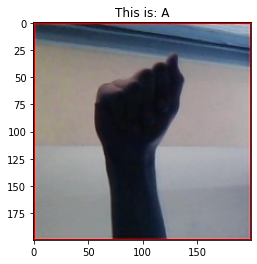

In [9]:
plt.imshow(images[0])
plt.title("This is: " + imageLabel[0])

In [10]:
# class Labels:
print("This are the class labels: ", classLabels)

This are the class labels:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [11]:
# split train and test images and also the class labels accordingly

X_train, X_test, y_train, y_test = train_test_split(images, imageLabel)

Text(0.5, 1.0, 'This is: space')

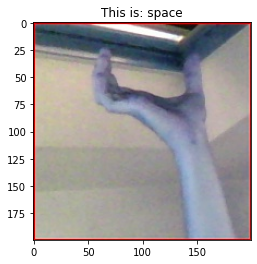

In [12]:
plt.imshow(X_train[0])
plt.title("This is: " + y_train[0])

In [13]:
# will normalize the images i.e., divide all the image pixel by 255
# will loop over all and divide the images / 255

for index in tqdm(range(0, len(X_train))):
  X_train[index] = X_train[index] / 255

for index in tqdm(range(0, len(X_test))):
  X_test[index] = X_test[index] / 255


100%|██████████| 363/363 [00:00<00:00, 1316.46it/s]


## Design the Model: VGG16

Using Transfer Learning of Imagenet weights (VGG16 has proved to be 92.7% accuracte with Imagenet dataset)



In [14]:
nos_of_Classes = len(classLabels)

image_input = tf.keras.Input(shape=(200, 200, 3))

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(nos_of_Classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                14877     
Total params: 15,254,877
Trainable params: 15,254,877
Non-trainable params: 0
_________________________________________________________________


In [16]:
# will only update the weights of the dense layer -> as using transfer learning to avoid time consumption
base_model.trainable = False

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

In [19]:
# converting string labels to interger labels

def stringMapInt(y):

  classLabelsDict = {}
  value = 0
  for label in classLabels:
    classLabelsDict[label] = value
    value = value + 1
  
  y_data = []

  for label in tqdm(y):
    y_data.append(classLabelsDict[label])
  
  return y_data


In [20]:
# One Hot Encoding for the classLabels

y_train_Label = stringMapInt(y_train)
y_test_Label = stringMapInt(y_test)

100%|██████████| 363/363 [00:00<00:00, 185674.68it/s]


In [21]:
y_train_oneHotEncoding = to_categorical(y_train_Label, num_classes=nos_of_Classes)
y_test_oneHotEncoding = to_categorical(y_test_Label, num_classes=nos_of_Classes)

In [22]:
y_train_oneHotEncoding

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [23]:
train_generator = datagen.flow(array(X_train), y_train_oneHotEncoding, batch_size=32)
validation_generator = datagen.flow(array(X_test), y_test_oneHotEncoding, batch_size=16)

In [ ]:
# checkpoint_filepath = '/content/'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)


In [24]:
epochs = 50

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) / 32,
    epochs=epochs,
    validation_data=validation_generator,
    # callbacks=[model_checkpoint_callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
33/33 [==============================] - 70s 978ms/step - loss: 3.4134 - accuracy: 0.0406 - val_loss: 3.2846 - val_accuracy: 0.1157
Epoch 2/50
33/33 [==============================] - 16s 484ms/step - loss: 3.1355 - accuracy: 0.1575 - val_loss: 2.8693 - val_accuracy: 0.2397
Epoch 3/50
33/33 [==============================] - 17s 487ms/step - loss: 2.5865 - accuracy: 0.3344 - val_loss: 2.1757 - val_accuracy: 0.4050
Epoch 4/50
33/33 [==============================] - 17s 491ms/step - loss: 1.8885 - accuracy: 0.5268 - val_loss: 1.6112 - val_accuracy: 0.6006
Epoch 5/50
33/33 [==============================] - 17s 486ms/step - loss: 1.3486 - accuracy: 0.6578 - val_loss: 1.3292 - val_accuracy: 0.5840
Epoch 6/50
33/33 [==============================] - 17s 492ms/step - loss: 1.1014 - accuracy: 0.7267 - val_loss: 0.9815 - val_accuracy: 0.7686
Epoch 7/50
33/33 [==============================] - 17s 490ms/step - loss: 0.8658 - accuracy: 0.8074 - val_loss: 0.8024 - val_accuracy: 0.8017

## predict the class labels for training data only


In [25]:
# y_test_Label - This is validation labels
y_valTest_prob = model.predict(np.array(X_test))

In [26]:
y_valTest_predcited = y_valTest_prob.argmax(axis=-1)

In [27]:
print(y_test_Label)
print(y_valTest_predcited)

[26, 3, 21, 4, 0, 2, 19, 6, 17, 3, 7, 4, 5, 6, 25, 15, 9, 10, 9, 19, 14, 16, 2, 16, 25, 0, 26, 22, 7, 23, 16, 16, 19, 14, 9, 21, 25, 10, 9, 3, 24, 0, 21, 26, 5, 27, 19, 14, 20, 5, 27, 18, 22, 5, 8, 8, 3, 14, 28, 0, 1, 15, 10, 2, 8, 8, 17, 11, 19, 11, 20, 13, 19, 3, 3, 23, 17, 10, 22, 10, 0, 19, 9, 4, 8, 16, 28, 4, 18, 6, 13, 15, 18, 27, 3, 27, 25, 5, 4, 20, 20, 24, 26, 4, 1, 12, 11, 17, 26, 3, 18, 26, 22, 18, 25, 22, 0, 26, 19, 21, 8, 10, 2, 23, 23, 4, 7, 18, 28, 5, 26, 26, 27, 1, 26, 20, 14, 22, 28, 13, 21, 17, 9, 17, 5, 25, 22, 6, 18, 14, 1, 13, 11, 27, 4, 8, 20, 7, 6, 2, 7, 14, 27, 12, 28, 12, 19, 1, 26, 8, 20, 0, 13, 17, 14, 26, 15, 4, 22, 24, 16, 28, 18, 3, 6, 8, 13, 22, 24, 23, 16, 25, 7, 11, 17, 24, 16, 21, 1, 1, 26, 13, 26, 12, 5, 18, 13, 25, 8, 22, 6, 0, 2, 28, 20, 11, 15, 4, 13, 24, 17, 24, 10, 23, 24, 3, 1, 8, 1, 10, 17, 27, 3, 9, 18, 14, 4, 2, 16, 13, 10, 20, 25, 24, 13, 5, 25, 6, 12, 8, 11, 26, 2, 14, 24, 11, 19, 17, 7, 7, 3, 13, 13, 17, 14, 1, 26, 20, 19, 24, 14, 26, 21, 

In [28]:
# Accuracy Score for Validation Test and predicted test labels
accuracy_score(y_test_Label, y_valTest_predcited)

0.9834710743801653

In [29]:
cmVT = confusion_matrix(y_test_Label, y_valTest_predcited)

In [30]:
df_cmVT = pd.DataFrame(cmVT, index = classLabels, columns = classLabels)

In [31]:
df_cmVT

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


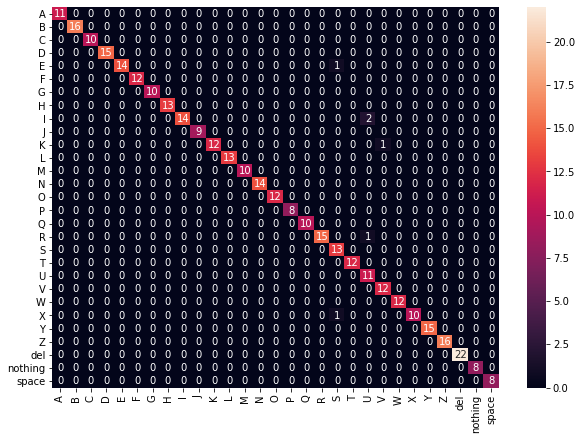

In [32]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cmVT, annot=True)

In [33]:
# F1 Score

f1_score(y_test_Label, y_valTest_predcited, average='macro')

0.9843980996947895

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nos_of_Classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oneHotEncoding[:, i], y_valTest_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_oneHotEncoding.ravel(), y_valTest_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

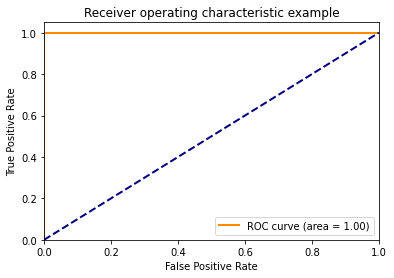

In [35]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [36]:
max(y_valTest_prob[3])

0.9997305

In [37]:
y_test_oneHotEncoding[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [38]:
y_test_Label[3]

4

In [39]:
y_valTest_prob[3]

array([2.38002380e-04, 2.24686141e-06, 2.40763200e-07, 6.66179005e-08,
       9.99730527e-01, 7.77794718e-10, 2.12440755e-05, 4.66723441e-06,
       1.55267435e-06, 1.75146937e-07, 1.41403149e-07, 6.21307783e-10,
       2.50822154e-08, 6.05538064e-10, 1.47516210e-09, 1.29145047e-14,
       1.15745434e-14, 1.69098480e-09, 5.69177928e-07, 1.62178632e-10,
       3.02641752e-07, 4.26679282e-11, 4.25649072e-09, 1.00954743e-07,
       1.23594628e-08, 2.55136854e-07, 2.39403827e-11, 5.90653332e-16,
       3.59947667e-14], dtype=float32)

In [40]:
y_valTest_predcited[3]

4

In [41]:
precision_score(y_test_Label, y_valTest_predcited, average='macro')

0.9853606163950992

In [42]:
recall_score(y_test_Label, y_valTest_predcited, average='macro')

0.9854483160517644

# This is for TEST NOW

In [43]:
def load_imagesTest(folderPath):
  images = []
  imageLabel = []

  classLabels = []

  # using sorted to organise the foldernames in alphabetic order
  folderList = list(sorted(os.listdir(folderPath)))
  # print(folderList)
  for folderName in tqdm(folderList):
    k = 0
    m = 0
    if '.DS_Store' not in folderName:
      classLabels.append(folderName)
      subFolder = os.path.join(folderPath, folderName)
      for filename in (list(sorted(os.listdir(subFolder)))):
        if '.DS_Store' not in filename:
          img = cv2.imread(os.path.join(subFolder,filename))
          # img = img/255
          if img is not None and m > 40:
              img = img/255
              images.append(img)
              imageLabel.append(folderName)
              k = k + 1;
          m = m + 1    
          if k == 50:
            break
          

  return images, imageLabel, classLabels

In [44]:
testDatasetFolderPath = '/content/asl_alphabet_train/asl_alphabet_train/'

In [45]:
testImages, testImageLabel, testClassLabels = load_imagesTest(testDatasetFolderPath)

100%|██████████| 29/29 [00:03<00:00,  9.08it/s]


In [46]:
predictTestLabelsProb = model.predict(np.array(testImages))

In [47]:
predictTestLabelsProb

array([[9.93165076e-01, 4.45365451e-08, 3.91142466e-11, ...,
        4.48764246e-12, 3.28275348e-16, 7.47325446e-14],
       [9.93668258e-01, 8.51148130e-08, 6.67858685e-11, ...,
        4.73236641e-12, 2.64613913e-16, 8.44590985e-14],
       [9.99291062e-01, 4.93175589e-09, 1.18271304e-11, ...,
        9.14501222e-13, 1.54428069e-17, 8.47027662e-14],
       ...,
       [4.96135499e-07, 1.14597434e-07, 6.95926647e-05, ...,
        8.79604556e-03, 1.85334642e-07, 2.16545654e-04],
       [2.10856069e-06, 1.90302714e-07, 1.41986209e-04, ...,
        1.30595127e-02, 1.76312028e-07, 2.73073936e-04],
       [2.28893402e-13, 8.02485519e-13, 5.68867691e-08, ...,
        1.19124070e-06, 4.23243515e-12, 9.99626398e-01]], dtype=float32)

In [48]:
y_classesPredicted = predictTestLabelsProb.argmax(axis=-1)

In [49]:

y_classes = []

for i in testImageLabel:
  if(i in classLabels):
    y_classes.append(classLabels.index(i))

In [50]:
print(y_classes)
print(y_classesPredicted[0:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [51]:
accuracy_score(y_classes, y_classesPredicted)

0.7806896551724138

In [52]:
cm = confusion_matrix(y_classes, y_classesPredicted)

In [53]:
df_cm = pd.DataFrame(cm, index = classLabels, columns = classLabels)

In [54]:
df_cm

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,32,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,43,0,0,0,0,1,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0
E,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,2,0,0,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,26,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,2,0,0,0,46,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


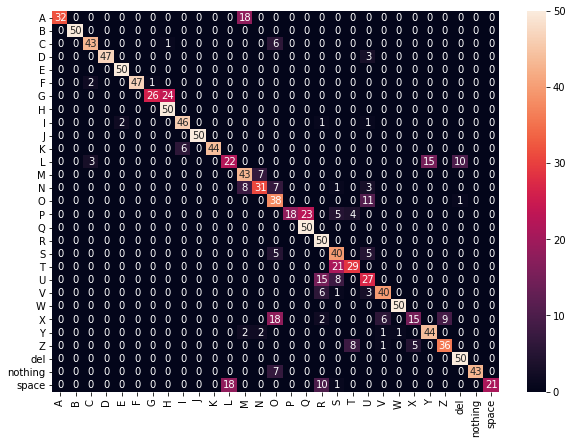

In [55]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [56]:
# F1 Score

f1_score(y_classes, y_classesPredicted, average='macro')

0.7743573125498232

In [57]:
precision_score(y_classes, y_classesPredicted, average='macro')

0.817825789814265

In [58]:
recall_score(y_classes, y_classesPredicted, average='macro')

0.7806896551724137

In [59]:
y_test_Encoding = to_categorical(y_classes, num_classes=nos_of_Classes)

In [60]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nos_of_Classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_Encoding[:, i], predictTestLabelsProb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_Encoding.ravel(), predictTestLabelsProb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

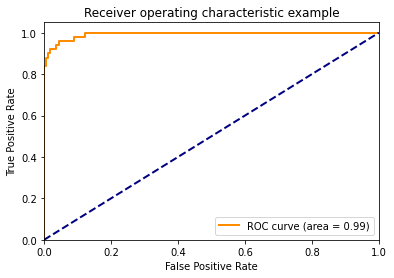

In [61]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()